In [10]:
from jedi.inference.recursion import recursion_limit
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool

from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

llm = init_chat_model("openai:gpt-4o-mini")

conn = sqlite3.connect(
    "chat.db",
    check_same_thread=False,
)


In [11]:
class State(MessagesState):
    pass


graph_builder = StateGraph(State)



In [12]:

@tool
def get_weather(city: str):
    """ Gets weather in city """
    return f"The weather in {city} is sunny"


llm_with_tool = llm.bind_tools(tools=[get_weather])


def chatbot(chatbot_state: State):
    response = llm_with_tool.invoke(chatbot_state["messages"])
    return {"messages": [response]}




In [13]:

tool_node = ToolNode(
    tools=[get_weather]
)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")

graph = graph_builder.compile(
    checkpointer=SqliteSaver(conn)
)


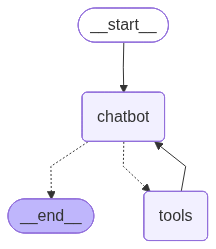

{'messages': [HumanMessage(content='what is the weather in machupichu', additional_kwargs={}, response_metadata={}, id='43bd00fb-aae5-4a52-8b76-25b211a30d0c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bo8bBtv4FG39Q8151aIHpINl', 'function': {'arguments': '{"city":"Machupicchu"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 51, 'total_tokens': 68, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CPJInahU6fGYxA9exOkuz6eY3W0xO', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e8154ba0-599e-43fd-9e86-9260546e9fee-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'Machupicchu

In [17]:
display(graph)

graph.invoke(
    {
        "messages": [{
            "role": "user",
            "content": "what is yourname"
        }]
    },
    config={
        "configurable": {
            "thread_id": "2"
        },
        "recursion_limit" : 3
    }
)


In [47]:
for state in graph.get_state_history(
    {
        "configurable": {
            "thread_id": "2",
        },
    }
):
    print(state)

StateSnapshot(values={'messages': [HumanMessage(content='what is the weather in machupichu', additional_kwargs={}, response_metadata={}, id='43bd00fb-aae5-4a52-8b76-25b211a30d0c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bo8bBtv4FG39Q8151aIHpINl', 'function': {'arguments': '{"city":"Machupicchu"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 51, 'total_tokens': 68, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CPJInahU6fGYxA9exOkuz6eY3W0xO', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e8154ba0-599e-43fd-9e86-9260546e9fee-0', tool_calls=[{'name': 'get_weather', 'args': {'

In [ ]:

# Stream 모드는 데이터베이스 연동을 다르게 해야 함.
async for event in graph.astream(
    {
        "messages": [
            {
                "role": "user",
                "content": "what is the weather in berlin, budapest and bratislava.",
            },
        ]
    },
    stream_mode="updates",
    # config={
    #     "configurable": {
    #         "thread_id": "2",
    #     },
    # },
):
    print(event)